In [6]:
# モジュールのインポート
from matplotlib import pyplot
from matplotlib import patches
import random
import numpy as np
import array
import math
import statistics

from itertools import repeat
from collections.abc import Sequence
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

In [7]:
# roomというclassを作る
class Room():
    def __init__(self,n,m,w=0,l=3,x=0,ud=3):
        self.n = n # number
        self.m = m # move_frequency
        self.w = w # width
        self.l = l # length
        self.x = x # exitpoint
        self.ud = ud # up and down
    # aとbとの距離
    def distance(self,b):
        return (abs( self.x - b.x )+ abs( self.ud - b.ud )) * self.m[b.n-1]
    # 壁
    def wall(self):
        return (self.w+self.l)*2
    # 床
    def floor(self):
        if self.w == 1:
            S = self.w*self.l+5*(8-self.l)+28
        elif self.l == 1:
            S = self.w*self.l+5*(8-self.w)+28
        elif self.w == 2 and self.l == 2:
            S = self.w*self.l+5
        else:
            S = (self.w*self.l)
        return S
    # 左の座標
    def leftpoint(self):
        return self.x-self.w/2
    # 右の座標
    def rightpoint(self):
        return self.x+self.w/2
    def display(self):
        print(f"番号:{self.n}　幅:{self.w}　奥行:{self.l}　入口:{self.x}　北南:{self.ud}")

In [8]:
# 遺伝子を生成
def room_gene():
    seq = random.sample(range(0,9),9) # 順番
    dim_gap = [random.randint(0,1) for i in range(54)]# 縦と横、北と南の部屋群とのずれ
    gene = seq + dim_gap
    return gene

# 遺伝子を用途ごとに分解し、二進数を十進数に変換
def disassembly(individual):
    seq = individual[:9]
    gap = individual[9:15]
    dim = individual[15:]
    deci_gap = 0
    _gap = gap[1:]
    for i, bit in enumerate(reversed(_gap)):
        if bit == 1:
            deci_gap += 2 ** i
    if gap[0] == 0:
        deci_gap = deci_gap * -1
    deci_dim = []
    n = 3
    for i in range(0, len(dim), n):
        decimal_num = 1
        for i, bit in enumerate(reversed(dim[i: i+n])):
            if bit == 1:
                decimal_num += 2 ** i
        deci_dim.append(decimal_num)
    return seq, deci_gap, deci_dim

# 割り当て
def quota(Rooms,individual):
    seq, gap, dim = disassembly(individual)
    dim_ = np.array(dim).reshape(8,2)
    copy_Rooms=Rooms.copy()
    Corridor = copy_Rooms.pop(0)
    # 幅と奥行き
    for room in copy_Rooms:
        n = room.n - 1
        room.w = dim_[n][0]
        room.l = dim_[n][1]
    ln,ls,c = 0, 0, 0
    divine = seq.index(0)
    seq_ = seq.copy()
    seq_.remove(0)
    # 入口
    rearrang_rooms = [copy_Rooms[i-1] for i in seq_]
    for rearrang_room in rearrang_rooms:
        c = c + 1
        if c <= divine:
            rearrang_room.ud = 0
            ln += rearrang_room.w
        else:
            rearrang_room.ud = 1
            ls += rearrang_room.w
    n, s = [0], [(ln-ls) / 2 + gap]
    for rearrang_room in rearrang_rooms:
        if rearrang_room.ud == 0:
            rearrang_room.x = sum(n) + rearrang_room.w/2
            n.append(rearrang_room.w)
        else:
            rearrang_room.x = sum(s) + rearrang_room.w/2
            s.append(rearrang_room.w)
    
    # 廊下
    if divine == 0 or divine == 8:
        Corridor.w = rearrang_rooms[-1].rightpoint()-rearrang_rooms[0].leftpoint()
        Corridor.x = rearrang_rooms[0].leftpoint()+Corridor.w/2
    else:
        Corridor.w = max(rearrang_rooms[divine-1].rightpoint(),rearrang_rooms[-1].rightpoint())\
                            - min(rearrang_rooms[0].leftpoint(),rearrang_rooms[divine].leftpoint())
        Corridor.x = min(rearrang_rooms[0].leftpoint(),rearrang_rooms[divine].leftpoint()) + Corridor.w/2
    
    # Pillarcount
    corrdinate = []
    for Room in copy_Rooms:
        if Room.ud == 0:
            corrdinate.extend([(Room.leftpoint(),1),(Room.leftpoint(),Room.l+1),(Room.rightpoint(),1),(Room.rightpoint(),Room.l+1)])
        else:
            corrdinate.extend([(Room.leftpoint(),0),(Room.leftpoint(),-Room.l),(Room.rightpoint(),0),(Room.rightpoint(),-Room.l)])
    corrdinate.extend([(Corridor.x-Corridor.w/2,0),(Corridor.x-Corridor.w/2,1),(Corridor.x+Corridor.w/2,0),(Corridor.x+Corridor.w/2,1)])
    Pillarcorrdinate = set(corrdinate)
    
    # 重複壁
    Duplication = 0
    for i in range(len(rearrang_rooms)-1):
        if i+1 < divine:
            Duplication += min(rearrang_rooms[i].w,rearrang_rooms[i+1].w)
        elif i+1 >= divine:
            Duplication += min(rearrang_rooms[i].w,rearrang_rooms[i+1].w)
    Duplication += sum([Rooms[i].w for i in range(len(Rooms))])
    
    # 柱の間隔
    if divine == 0 or divine == 8:
        max_interval = Corridor.rightpoint()-Corridor.leftpoint()
    else:
        interval = [abs(Corridor.leftpoint()-rearrang_rooms[0].leftpoint()),abs(Corridor.leftpoint()-rearrang_rooms[divine].leftpoint()),
                     abs(Corridor.rightpoint()-rearrang_rooms[divine-1].rightpoint()),abs(Corridor.rightpoint()-rearrang_rooms[-1].rightpoint())]
        max_interval = max(max(interval),max(dim))
    
    Rooms = [Corridor] + copy_Rooms
    return Rooms,Pillarcorrdinate,Duplication,max_interval

# 配置
def conf(best_ind):
    seq, gap, dim = disassembly(best_ind)
    global Rooms
    Rooms,Pillarcorrdinate,Duplication,max_interval = quota(Rooms,best_ind)
    copy_Rooms=Rooms.copy()
    copy_Rooms.pop(0)
    fig, ax = pyplot.subplots()

    ax.set_xlim([Corridor.x-Corridor.w/2-1,Corridor.x+Corridor.w/2+1])
    ax.set_ylim([-10,10])
    ax.grid()

    for room in copy_Rooms:
        if room.ud == 0:
            ud = 1
        else:
            ud = -1*room.l
        r = patches.Rectangle( xy=(room.x-room.w/2,ud) ,facecolor="white",edgecolor="red", width=room.w, height=room.l) 
        ax.add_patch(r)
    ax.add_patch(patches.Rectangle( xy=(Corridor.x-Corridor.w/2,0) ,facecolor="white",edgecolor="black", width=Corridor.w, height=1))
    
    Pillarcorrdinate = list(Pillarcorrdinate)
    for i in range(len(Pillarcorrdinate)):
        x,y = Pillarcorrdinate[i]
        pyplot.scatter(x, y, marker=",",color="k")
    
    for i in seq:
        if i== 0:
            Corridor.display()
        else:
            copy_Rooms[i-1].display()
    print(f"北と南のずれ:{gap} 柱の数:{len(Pillarcorrdinate)} 重複壁:{Duplication} 柱間:{max_interval}")
    
    pyplot.axis('off')
    pyplot.show()

In [9]:
# 設定（部屋番号,部屋と部屋の間の移動コスト）
Corridor = Room(0,0,l=1,ud=0.5) # 廊下
Room_1 = Room(1,[0,1,1,1,1,1,1,1])
Room_2 = Room(2,[1,0,1,1,1,1,1,1])
Room_3 = Room(3,[1,1,0,1,1,1,1,1])
Room_4 = Room(4,[1,1,1,0,1,1,1,1])
Room_5 = Room(5,[1,1,1,1,0,1,1,1])
Room_6 = Room(6,[1,1,1,1,1,0,1,1])
Room_7 = Room(7,[1,1,1,1,1,1,0,1])
Room_8 = Room(8,[1,1,1,1,1,1,1,0])

Rooms = [Corridor,Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]

In [10]:
# 評価関数
def Eval(individual):
    seq, gap, dim = disassembly(individual)
    global Rooms
    Rooms,Pillarcorrdinate,Duplication,max_interval = quota(Rooms,individual)
    copy_Rooms=Rooms.copy()
    D = []# 距離
    F = []# 床
    W = []# 壁
    P = len(Pillarcorrdinate)# 柱の数
    copy_Rooms.pop(0)
    for room in copy_Rooms:
        D.append(sum([room.distance(i) for i in Rooms]))
        F.append(room.floor())
        W.append(room.wall())

    # construction_cost
    a,b,c=3000,109,14200
    dfl,dwl,wbs,dbs,hbm,hbs,wbm,h=0.12,0.1,0.6,0.3,0.8,0.92,0.6,3.1
    aw = 0.1*max_interval
    # 床
    C1 = 2*(a+100*b*dfl+c*dfl)+100*b*dbs+c*dbs
    # 壁
    C2 = a*(wbm-dwl+2*(hbm-dfl))+(100*b+c)*wbm*(hbm-dfl)+2*a*(h-hbm)+(100*b+c)*dwl*(h-hbm)+2*a*(hbs-dfl)+(100*b+c)*(wbs*(hbs-dfl))
    # 柱
    C3 = 4*a*aw*(h-dfl)+100*b*aw*aw*(h-dfl)+c*aw*aw*(h-dfl)
    Cc = C1*sum(F)+C2*(sum(W)-Duplication)+C3*P
    #　transportation_cost
    Tc = sum(D)

    return Cc,Tc

In [11]:
# 交叉
def CX(ind1, ind2):
    seq1, gap1, dim1 = ind1[:9], ind1[9:15], ind1[15:]
    seq2, gap2, dim2 = ind2[:9], ind2[9:15], ind2[15:]
    
    divine1 = seq1.index(0)
    divine2 = seq2.index(0)
    seq1.remove(0)
    seq2.remove(0)
    seq1 = [x-1 for x in seq1]
    seq2 = [x-1 for x in seq2]
    
    size = min(len(seq1),len(seq2))
    p1, p2 = [0] * size, [0] * size
    
    # Initialize the position of each indices in the individuals
    for i in range(size):
        p1[seq1[i]] = i
        p2[seq2[i]] = i
    # Choose crossover points
    cxpoint1 = random.randint(0, size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = seq1[i]
        temp2 = seq2[i]
        # Swap the matched value
        seq1[i], seq1[p1[temp2]] = temp2, temp1
        seq2[i], seq2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    seq1 = [x+1 for x in seq1]
    seq2 = [x+1 for x in seq2]
    seq1.insert(divine1,0)
    seq2.insert(divine2,0)
    
    c1 = list()
    c2 = list()

    for i in range(int(len(dim1)/6)):
        if random.random() < 0.5:
            c1.append(dim1[i:i+6])
            c2.append(dim2[i:i+6])
        else:
            c1.append(dim2[i:i+6])
            c2.append(dim1[i:i+6])
        
    gap1,gap2 = gap2,gap1
    
    ind1 = seq1 + gap1 + c1
    ind2 = seq2 + gap2 + c2
    return ind1, ind2

In [12]:
# 突然変異
def MUT(individual,indpb):
    seq, gap, dim = individual[:9], individual[9:15], individual[15:]
    divine = seq.index(0)
    seq.remove(0)
    size = len(seq)
    swpoint1 = random.randint(0, size - 1)
    swpoint2 = random.randint(0, size - 2)
    if swpoint2 >= swpoint1:
        swpoint2 += 1
    else:  # Swap the two cx points
        swpoint1, swpoint2 = swpoint2, swpoint1

    seq[swpoint1], seq[swpoint2] = \
        seq[swpoint2], seq[swpoint1]

    swpoint1x6, swpoint2x6 = swpoint1*6, swpoint2*6
    dim[swpoint1x6:swpoint1x6+6], dim[swpoint2x6:swpoint2x6+6] = \
        dim[swpoint2x6:swpoint2x6+6], dim[swpoint1x6:swpoint1x6+6]

    for i in range(len(gap)):
        if random.random() < indpb:
            gap[i] = type(gap[i])(not gap[i])
    individual = seq + gap + dim
    
    return individual,

In [13]:
# 定義
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 初期条件を構築
toolbox.register("individual", tools.initIterate, creator.Individual, room_gene)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", Eval)
toolbox.register("mate", CX)
toolbox.register("mutate", MUT,indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=30)

In [14]:
def main(n,CXPB, MUTPB ,NGEN):
    pop = toolbox.population(n=n)
    CXPB, MUTPB ,NGEN = CXPB, MUTPB ,NGEN

    fitnesses = list(map(toolbox.evaluate, pop))

    Cc,Tc,normal_fitnesses = [],[],[]
    for i in range(n):
        Cc.append(fitnesses[i][0])
        Tc.append(fitnesses[i][1])
    m_Cc,m_Tc = statistics.mean(Cc),statistics.mean(Tc)
    v_Cc = statistics.stdev(Cc)
    v_Tc = statistics.stdev(Tc)
    Cc = (Cc-m_Cc)/v_Cc
    Tc = (Tc-m_Tc)/v_Tc
    a1, a2 = 1, 1
    R = a1*Cc + a2*Tc
    for i in range(n):
        normal_fitnesses.append((R[i],))
    for ind, fit in zip(pop, normal_fitnesses):
        ind.fitness.values = fit
    fits = [ind.fitness.values[0] for ind in pop]
    
    mean = statistics.mean(fits)
    std = statistics.stdev(fits)
    log = [[min(fits),max(fits),mean,std]]

    print("gen　　　nevals　　　avg　　　std　　　min　　　max" )
    g = 0
    while  g < NGEN: #and max(R) != min(R):
        g = g + 1
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))

        Cc, Tc, normal_fitnesses = [],[],[]
        for i in range(len(invalid_ind)):
            Cc.append(fitnesses[i][0])
            Tc.append(fitnesses[i][1])
        Cc = (Cc-m_Cc)/v_Cc
        Tc = (Tc-m_Tc)/v_Tc
        R = a1*Cc + a2*Tc
        for i in range(len(invalid_ind)):
            normal_fitnesses.append((R[i],))
        for ind, fit in zip(invalid_ind, normal_fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        fits = [0 if e == "NaN" or math.isnan(e) else e for e in fits]
        # 母集団の最小、最大、平均、標準偏差を表示
        mean = statistics.mean(fits)
        std = statistics.stdev(fits)
        log.append([min(fits),max(fits),mean,std])

        print('%2d　　　%4d　　　%5d　　%5d　　%5d　　%5d' % (g,len(invalid_ind),round(mean, 3),round(std,3),round(min(fits),3),round(max(fits),3)))
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, log

gen　　　nevals　　　avg　　　std　　　min　　　max
 1　　　 934　　　   -3　　    0　　   -3　　   -1
 2　　　 944　　　   -3　　    0　　   -3　　   -3
 3　　　 935　　　   -3　　    0　　   -3　　   -3
 4　　　 952　　　   -3　　    0　　   -3　　   -3
 5　　　 948　　　   -3　　    0　　   -3　　   -3
 6　　　 948　　　   -3　　    0　　   -3　　   -3
 7　　　 947　　　   -3　　    0　　   -3　　   -3
 8　　　 949　　　   -3　　    0　　   -3　　   -3
 9　　　 958　　　   -3　　    0　　   -3　　   -3
10　　　 934　　　   -3　　    0　　   -3　　   -3
11　　　 934　　　   -3　　    0　　   -3　　   -3
12　　　 939　　　   -3　　    0　　   -3　　   -3
13　　　 942　　　   -3　　    0　　   -3　　   -3
14　　　 929　　　   -3　　    0　　   -3　　   -3
15　　　 940　　　   -3　　    0　　   -3　　   -3
16　　　 932　　　   -3　　    0　　   -3　　   -3
17　　　 938　　　   -3　　    0　　   -3　　   -3
18　　　 939　　　   -3　　    0　　   -3　　   -3
19　　　 939　　　   -3　　    0　　   -3　　   -3
20　　　 943　　　   -3　　    0　　   -3　　   -3
21　　　 939　　　   -3　　    0　　   -3　　   -3
22　　　 930　　　   -3　　    0　　   -3　　   -3
23　　　 955　　　   -3　　    0　　   -3　　   -3
24　　　 943　　　   -3　　    0　　   -3　　   -3
25　　　 919　　　   -3　　    0　　 

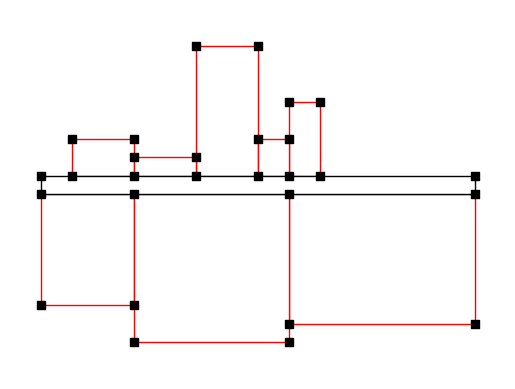

In [15]:
# 実行
n = 1000
CXPB, MUTPB ,NGEN = 0.8, 0.7, 30
if __name__ == "__main__":
    best_ind, log = main(n,CXPB, MUTPB ,NGEN)
print(Eval(best_ind))
conf(best_ind)

(11058903.24, 638.0)
番号:4　幅:6　奥行:3　入口:3.0　北南:0
番号:0　幅:32.0　奥行:1　入口:2.0　北南:0.5
番号:1　幅:7　奥行:3　入口:-10.5　北南:1
番号:8　幅:7　奥行:4　入口:-3.5　北南:1
番号:3　幅:4　奥行:2　入口:2.0　北南:1
番号:2　幅:2　奥行:8　入口:5.0　北南:1
番号:7　幅:2　奥行:7　入口:7.0　北南:1
番号:6　幅:8　奥行:2　入口:12.0　北南:1
番号:5　幅:2　奥行:8　入口:17.0　北南:1
北と南のずれ:-1 柱の数:28 重複壁:95.0 柱間:14.0


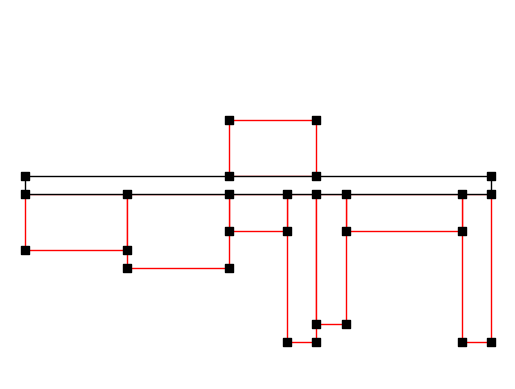

In [16]:
Rooms = [Corridor,Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]
individual = room_gene()
Best = [0, 7, 6, 5, 8, 4, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
print(Eval(individual))
conf(individual)